<a href="https://colab.research.google.com/github/jstarace/CS_504_Assignment3_Vakanski/blob/main/CS504_Vakanski_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

### The following is a complete walk-through of Assignment #3 for CS 504: ST Adversarial Machine Learning, taught by Dr. Vakanski at the University of Idaho in the Spring of 2023.  The assignment is being made available to assist in the understanding of future related assignments at the request of Dr. Vakanski.

### The assignment is broken down into 2 parts.
1. Adversarial Traning defense against evasion attacks
1. Poisoning attacks against deep learning classification models

For this assignment I used Google Colab for the training of the models and completion of the assignment.  It is recommend that the same or similar is used.

# Notebook Setup

## Setup and Configuration

Before diving into the assignment we want to make sure our environment has all the necessary libraries and connections

In [1]:
# Connect to Google Drive.
# All images required for the assignment were either provided by Dr. Vakanski or were publicly available
# Images were loaded onto google drive for ease of access

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install the adversarial robustness toolbox so that we can work with adversarial models
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 58.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


### Imports

In [3]:
# For inline matplot use
%matplotlib inline

# Import the following libraries

import os
import cv2
import sys
import keras
import random
import imageio
import tarfile
import natsort
import warnings
import numpy as np
import tensorflow as tf
import keras.backend as k
import matplotlib.pyplot as plt

In [4]:
# From installed and available libraries import these specific classes

from os import listdir

from keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.applications.imagenet_utils import preprocess_input

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.tools.docs.doc_controls import T
from tensorflow.keras.utils import to_categorical
from tensorflow.python.ops.math_ops import TruncateDiv
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D

from art.estimators.classification import KerasClassifier
from art.estimators.classification import SklearnClassifier

from art.attacks.evasion import BoundaryAttack
from art.attacks.evasion import FastGradientMethod,ProjectedGradientDescent,DeepFool
from art.utils import to_categorical

from skimage.util import compare_images
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec
from skimage import data, transform, exposure

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from re import U

In [5]:
# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Supress warnings
warnings.filterwarnings('ignore')

In [6]:
# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.12.0
Keras version:2.12.0


### Definitions

The following are the definitions for methods we will use during the assignment

#### Plotting loss and accuracy

In [7]:
# Simple method used to print a models accuracy and loss.  Pass the method
# the history and both accuracy and loss will be displayed

def plot_accuracy_loss(the_history):
    # plot the accuracy and loss
    train_loss = the_history.history['loss']
    val_loss = the_history.history['val_loss']
    acc = the_history.history['accuracy'] 
    val_acc = the_history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

#### Model Definitions

In [8]:

# For this assignment transfer learning was used for the base models.
# Specifically resnet models were used.  You may note that when using the
# ResNet models provided by Keras, their documentation mentions preprocessing
# the images.  This is intentionally left out as it caused issues with the
# accuracy of the predicitions.

# As the inputs and classes may change we pass those as variables to provide a
# more robust method for use.
def build_resnet50(input_shape, class_count):
  
  #Transfer the model into a generic base model
  baseModel = tf.keras.applications.ResNet50V2(
      include_top = False,
      weights="imagenet",
      input_shape = input_shape,
      pooling = "avg",
      classes = class_count
  )

  # Set each layer of the base model to trainable so it can be customized to our
  # datasets
  for layer in baseModel.layers:
    layer.trainable = True
  
  # Create a new sequential model
  model = Sequential()

  # Add the transfered model
  model.add(baseModel)

  # Customize the final layers of the ResNet model by adding additional layers
  model.add(Flatten())
  model.add(Dense(1024,
                  activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(128,
                  activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(64,
                  activation = 'relu'))
  model.add(Dense(class_count, activation = 'softmax', name = 'output'))

  return model

#### Attack Definitions

In [9]:
def pgdAttack(eps, classifier, imgTest, targeted, verbose, labels=None):
  attackPgd = ProjectedGradientDescent(estimator = classifier,
                                       norm = np.inf,
                                       eps = eps,
                                       eps_step = 0.01,
                                       max_iter = 200,
                                       targeted = targeted,
                                       verbose = verbose,
                                       batch_size = 256)
  if targeted == True and labels is not None:
    return attackPgd.generate(imgTest, labels)
  elif targeted == False:
    return attackPgd.generate(imgTest)

def generate_pgd_img(classifier, provided_array):
  attack_pgd = ProjectedGradientDescent(estimator = classifier, eps = 20.0/255.0, eps_step = 0.01, max_iter = 100, targeted = False, verbose = False)
  pgd_array = []
  for x in provided_array:
    img = attack_pgd.generate(x.reshape(1, 224, 224, 3))
    img = img[0]
    pgd_array.append(img)
  pgd_array = np.array(pgd_array, dtype = np.float32)
  return pgd_array

def generate_fgsm_img(classifier, provided_array):
  attack_fgsm = FastGradientMethod(estimator = classifier, eps = 20.0/255.0)
  fgsm_array = []
  for x in provided_array:
    img = attack_fgsm.generate(x.reshape(1, 224, 224, 3))
    img = img[0]
    fgsm_array.append(img)
  fgsm_array = np.array(fgsm_array, dtype = np.float32)
  return fgsm_array

def generate_df_img(classifier, provided_array):
  attack_df = DeepFool(classifier = classifier, max_iter = 100, verbose = False)
  df_array = []
  for x in provided_array:
    img = attack_df.generate(x.reshape(1, 224, 224, 3))
    img = img[0]
    df_array.append(img)
  df_array = np.array(df_array, dtype = np.float32)
  return df_array

#### Helper methods for randomization

In [10]:
# Generate an array of unique random ints used for selecting random indices
def random_array(c, upper):
  random_list = []
  while len(random_list) < c:
    #for i in range(c):
    r = random.randint(0, upper-1)
    if r not in random_list:
      random_list.append(r)
  return random_list

# Get a subset from provided array
def get_subset(subset, provided_images, provided_labels):
  temp_img = []
  temp_labels = []
  for x in subset:
    temp_img.append(provided_images[x])
    temp_labels.append(provided_labels[x])
  temp_img = np.array(temp_img, dtype = np.float32)
  temp_labels = np.array(temp_labels, dtype = np.float32)
  return temp_img, temp_labels

# Get predictions for any model
def generate_predictions(model, images):
  labels = []
  i = 0
  for x in images:
    labels.append(np.argmax(model.predict(images[i].reshape(1, 224, 224, 3))))
    i += 1
  labels = np.array(labels, dtype = np.float32)
  return labels 

#### Image Loader

In [11]:
def load_images(directory):

    imgs_list = []

    # List of all images in the directory
    imgs_list_1 = listdir(directory)
    # Make sure that the images are sorted 
    imagesList = natsort.natsorted(imgs_list_1)

    # Read the images as numpy arrays
    for i in range(len(imagesList)):
          tmp_img = cv2.imread(os.path.join(directory, imagesList[i]))
          img_arr = np.array(tmp_img)
          imgs_list.append(img_arr/255.)
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)

    return imgs

### Global variables

In [12]:
# Label Encoder for loading in data
le = LabelEncoder()

# Define a save path for use when training models
save_path = '/content/drive/MyDrive/Colab Notebooks/CS_504/Assignment_3/Saves/'

# Define the path for weights to be stored
weight_path = 'Weights/'

# Define the path for the model to be stored
model_path = 'Models/'

# Define the extention for weights/models
ext = '.h5'

# Part 1

## Step 1

### About the data

For this part of the assignment we will be using a subset of the [WikiArt Dataset](https://paperswithcode.com/dataset/wikiart) that contains 3,988 paintings by 10 artists.  The images are stored in a directory 'Paintings.zip' and the labels in a csv file 'labels_paintings.csv'.

We will be using 20% of the data for the test set and another 20% of the data for a validation set.

### Load Data

In [13]:
# Uncompress the dataset 
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/CS_504/Assignment_3/data/Paintings.zip" -d "sample_data/"

In [14]:
# Load the images
all_images = load_images('sample_data/Paintings')
print('Shape of the images:', all_images.shape)

# Load the labels
all_labels = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/CS_504/Assignment_3/data/labels_paintings.csv', delimiter=',', dtype=str)
image_labels = le.fit_transform(all_labels)
print('Shape of the labels:', image_labels.shape)

Shape of the images: (3988, 224, 224, 3)
Shape of the labels: (3988,)


In [15]:
# Split the data into 2 sets of data
# 1. A trainval set that will later be split into the training and validation sets
# 2. A test set which will be 20% of all data

# By setting the random state, we can ensure consistency when creating the datasets
# This allows us to focus on fine tuning our models
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, image_labels, test_size=0.2, random_state=12)

# Using the trainval sets, we split the data again into our training and validation sets
# The validation set will be 20% of the remaining data and the remainder will be 
# our training set
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=12)

# With all the necessary info loaded, we can free up space by deleting the imported images
del all_images

In [16]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images 
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

# A list with the names of the image classes
label_names = np.unique(all_labels)

Images train shape: (2552, 224, 224, 3) - Labels train shape: (2552,)
Images validation shape: (638, 224, 224, 3) - Labels validation shape: (638,)
Images test shape: (798, 224, 224, 3) - Labels test shape: (798,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.4542102633140372
Data type float64


### Plot images with ground-truth labels

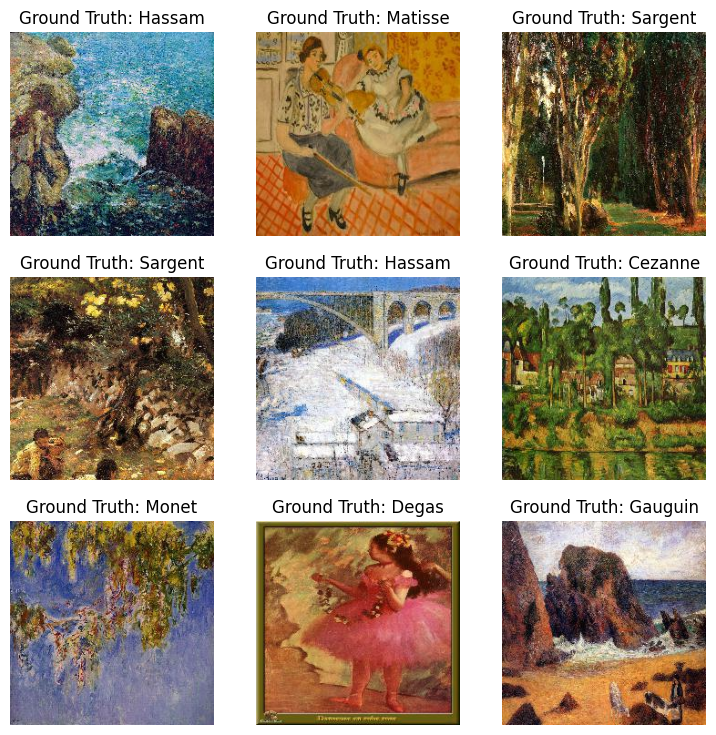

In [17]:
plt.figure(figsize=(9, 9))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Ground Truth: ' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

### Train a deep learning model above 70% accuracy

#### Paths and variables

In [18]:
weight_name = 'atd_weights_'
atd = 'atd/'

In [19]:
input = (224, 224, 3)
NUM_CLASSES = len(label_names)
batch = 32
epochs = 100
iterations = 3

In [20]:
adam = tf.keras.optimizers.legacy.Adam(learning_rate = .0001)

model_monitor = EarlyStopping(monitor='val_loss',
                            min_delta=1e-3,
                            patience=30,
                            verbose=0,
                            mode='auto')

#### Train the model

In [ ]:
# Because initialization of the weights is random, we will loop through model 
# training based on the iteration value set above.  All accuracies and histories
# will be stored in the arrays we create.  Later we will compare values and load
# the model with the best performance
accuracy = []
histories = []

for i in range(iterations):
  model = build_resnet50(input, NUM_CLASSES)
  model.compile(loss="sparse_categorical_crossentropy",
              optimizer = adam,
              metrics=['accuracy'])
  print("Iteration: " + str(i+1) + " of " + str(iterations))
  path = save_path + weight_path + weight_name + str(i) + ext
  print("Weights will be saved here: " + path)
  model_checkpointer = ModelCheckpoint(path,
                                       verbose = 1,
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'auto')
  history = model.fit(
      train_images,
      train_labels,
      verbose=1,
      epochs = epochs,
      batch_size = batch,
      callbacks = [model_monitor, model_checkpointer],
      validation_data = (val_images, val_labels)
  )

  histories.append(history)
  loss_test, accuracy_test = model.evaluate(test_images, test_labels)
  print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))
  accuracy.append(accuracy_test)

#### Verify the best model and load it

In [ ]:
# Print the index with the best accuracy
best = [index for index, item in enumerate(accuracy) if item ==max(accuracy)]
the_value = best[0]
print("The best index is: " + str(the_value))

In [ ]:
best_model = build_resnet50(input, NUM_CLASSES)
best_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=adam,
                metrics=['accuracy'])

best_path = save_path + weight_path + weight_name + str(the_value) + ext
best_model.load_weights(best_path)
best_model.summary()
plot_accuracy_loss(histories[the_value])
best_loss_test, best_accuracy_test = best_model.evaluate(test_images, test_labels)
print('Accuracy on test data: {:4.2f}%'.format(best_accuracy_test * 100))

#### Save best model
This allows us to skip retraining the model should we need to come back to this at a later time

In [ ]:
best_model.save(save_path + model_path + atd)

## Step 2

### Load in the model from Step 1

In [21]:
the_model = keras.models.load_model(save_path + model_path + atd)
the_model.summary()
loss, acc = the_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Instructions for updating:
Colocations handled automatically by placer.


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_16 (Flatten)        (None, 2048)              0         
                                                                 
 dense_71 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_55 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_57 (Dropout)        (None, 1024)              0         
                                                                 
 dense_72 (Dense)            (None, 128)               131200    
                                                     

### Store loss and acc for comparison later

In [22]:
the_accuracies = []
the_losses = []
the_accuracies.append(acc)
the_losses.append(loss)

### Select 100 random images from the test set

In [23]:
subset = random_array(100, len(test_images))
subset_images, subset_labels = get_subset(subset, test_images, test_labels)
true_labels = subset_labels.copy()

print('Subset Image shape: {} - Subset Labels shape: {}'.format(subset_images.shape, subset_labels.shape))

Subset Image shape: (100, 224, 224, 3) - Subset Labels shape: (100,)


### Test model on subset of images

In [24]:
loss, acc = the_model.evaluate(subset_images, subset_labels)
the_accuracies.append(acc)
the_losses.append(loss)
print('Model performance on subset, accuracy: {:5.2f}%'.format(100 * acc))

Model performance on subset, accuracy: 68.00%


### Create Classifier for Adversarial models

In [25]:
classifier = KerasClassifier(model = the_model, clip_values=(0,1), use_logits = False)

### Adversarial Attacks

#### PGD

In [26]:
# Generate the images
pgd = generate_pgd_img(classifier, subset_images)

# Generate the predictions
pgd_labels = generate_predictions(the_model, pgd)

# Evaluate the model
loss, acc = the_model.evaluate(pgd, subset_labels)

# Store the accuracy and loss
the_accuracies.append(acc)
the_losses.append(loss)

# Print the accuracy
print('Accuracy on pgd data: {:4.2f}%'.format(acc * 100))

Accuracy on pgd data: 15.00%


#### FGSM

In [27]:
# Generate the images
fgsm = generate_fgsm_img(classifier, subset_images)

# Generate the predictions
fgsm_labels = generate_predictions(the_model, fgsm)

# Evaluate the model
loss, acc = the_model.evaluate(fgsm, subset_labels)

# Store the accuracy and loss
the_accuracies.append(acc)
the_losses.append(loss)

# Print the accuracy
print('Accuracy on fgsm data: {:4.2f}%'.format(acc * 100))

Accuracy on fgsm data: 13.00%


#### Deep Fool

In [28]:
# Generate the images
df = generate_df_img(classifier, subset_images)

# Generate the predictions
df_labels = generate_predictions(the_model, df)

# Evaluate the model
loss, acc = the_model.evaluate(df, subset_labels)

# Store the accuracy and loss
the_accuracies.append(acc)
the_losses.append(loss)

# Print the accuracy
print('Accuracy on deep fool data: {:4.2f}%'.format(acc * 100))

Accuracy on deep fool data: 10.00%


### Print Images

#### PGD

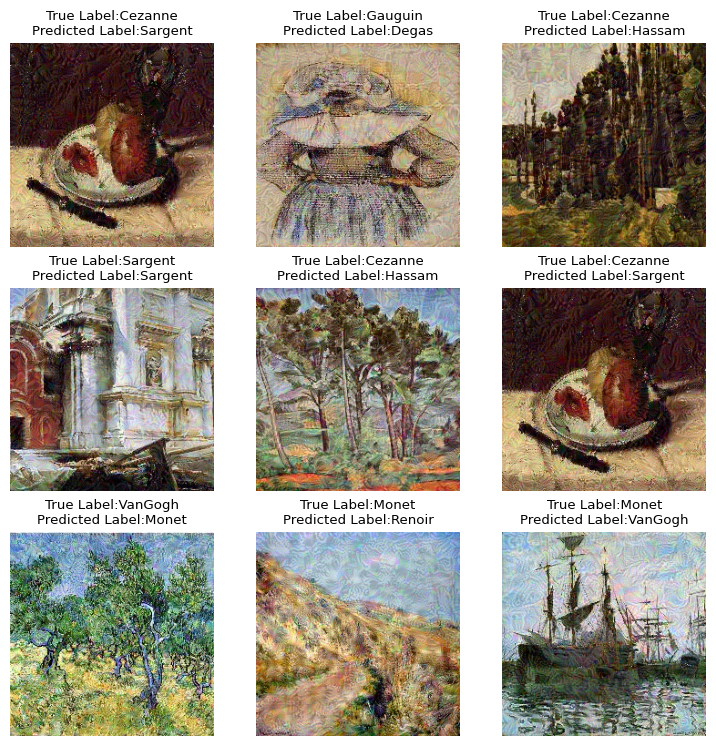

In [29]:
plt.figure(figsize=(9, 9))
plt.rcParams.update({'font.size': 8})
for n in range(9):
    i = np.random.randint(0, len(pgd), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(pgd[i[0]].reshape(224, 224, 3))
    plt.title("True Label:{}\nPredicted Label:{}".format(label_names[int(true_labels[i[0]])], label_names[int(pgd_labels[i[0]])]))
    plt.axis('off')

#### FGSM

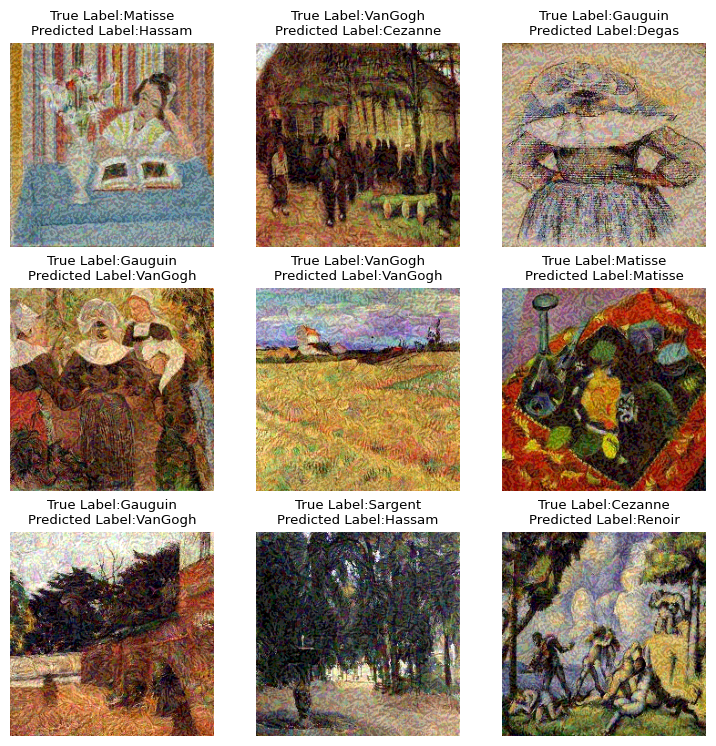

In [30]:
plt.figure(figsize=(9, 9))
plt.rcParams.update({'font.size': 8})
for n in range(9):
    i = np.random.randint(0, len(fgsm), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(fgsm[i[0]].reshape(224, 224, 3))
    plt.title("True Label:{}\nPredicted Label:{}".format(label_names[int(true_labels[i[0]])], label_names[int(fgsm_labels[i[0]])]))
    plt.axis('off')

#### Deep Fool

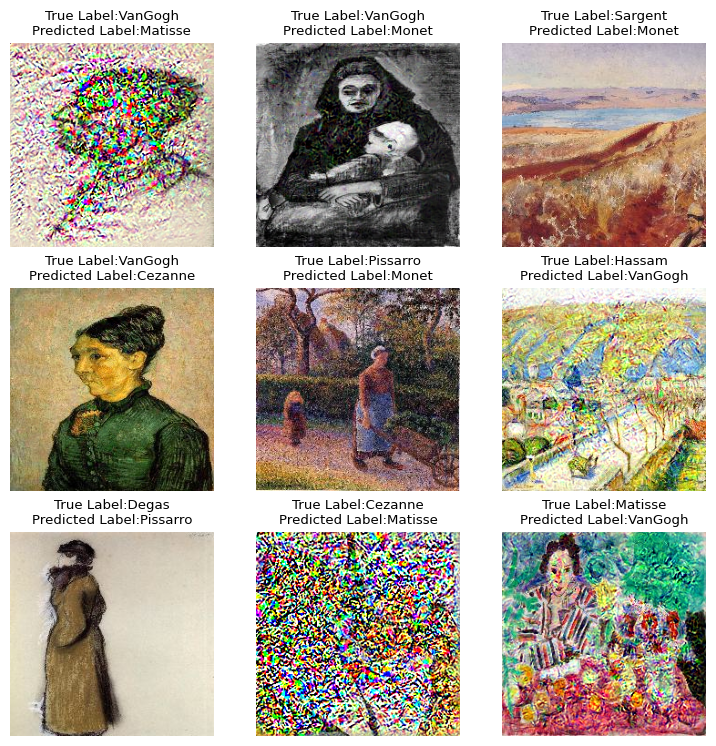

In [31]:
plt.figure(figsize=(9, 9))
plt.rcParams.update({'font.size': 8})
for n in range(9):
    i = np.random.randint(0, len(df), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(df[i[0]].reshape(224, 224, 3))
    plt.title("True Label:{}\nPredicted Label:{}".format(label_names[int(true_labels[i[0]])], label_names[int(df_labels[i[0]])]))
    plt.axis('off')

## Step 3

### Create a Defense against adversarial attacks

In [32]:
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer

# Create a new classifier for the defense testing
ATD_Classifier = KerasClassifier(clip_values=(0,1), model = the_model, use_logits = False)

# Generate the attacks using the new classifier that will be used for training
attacks = ProjectedGradientDescent(ATD_Classifier, eps=10.0/255.0, eps_step = 0.01, max_iter = 25)

In [ ]:
# Perform Adversarial Training
# As needed modify the epochs and batch size to fine tune the training for robustness
trainer = AdversarialTrainer(ATD_Classifier, attacks, ratio=0.5)
trainer.fit(train_images, train_labels, nb_epochs = 10, batch_size = 16)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Generate predictions
atd_pred = np.argmax(ATD_Classifier.predict(test_images), axis=1)

# Count Correctly predicted
correctly_predicted = np.sum(atd_pred == np.argmax(test_labels, axis = 0))

# Store accuracy for all images in test data set
the_accuracies.append(correctly_predicted/len(test_images))

print('Accuracy for clean test images with Adversarially trained model: {:4.2f}%'.format((correctly_predicted/len(test_images)) * 100))

## Step 4

### Test Adversarial Trained Defense on Subset Images

In [ ]:
atd_subset =  np.argmax(ATD_Classifier.predict(subset_images), axis=1)
sub_predicted = np.sum(atd_subset == np.argmax(subset_labels, axis = 0))
the_accuracies.append(sub_predicted/len(subset_images))

### Test Adversarial Trained Defense on PGD Images

In [ ]:
atd_pgd =  np.argmax(ATD_Classifier.predict(pgd), axis=1)
pgd_predicted = np.sum(atd_pgd == np.argmax(subset_labels, axis = 0))
the_accuracies.append(pgd_predicted/len(subset_images))

### Test Adversarial Trained Defense on FGSM Images

In [ ]:
atd_fgsm =  np.argmax(ATD_Classifier.predict(fgsm), axis=1)
fgsm_predicted = np.sum(atd_fgsm == np.argmax(subset_labels, axis = 0))
the_accuracies.append(fgsm_predicted/len(subset_images))

### Test Adversarial Trained Defense on Deep Fool Images

In [ ]:
atd_df =  np.argmax(ATD_Classifier.predict(df), axis=1)
df_predicted = np.sum(atd_df == np.argmax(subset_labels, axis = 0))
the_accuracies.append(df_predicted/len(subset_images))

### Display Results

In [ ]:
print("1 = Standard accuracy on test dataset (about 800 images)")
print("2 = Standard accuracy on the subset of 100 test images")
print("3 = Robust accuracy on FGSM attacked subset of 100 test images")
print("4 = Robust accuracy on PGD attacked subset of 100 test images")
print("5 =Robust accuracy on DF attacked subset of 100 test images\n")

print("\t\t\t   1\t   2\t   3\t   4\t   5")
print("Standard\t\t{:5.2f}%\t{:5.2f}%\t{:5.2f}%\t{:5.2f}%\t{:5.2f}%".format(the_accuracies[0]*100, 
                                                                            the_accuracies[1]*100, 
                                                                            the_accuracies[2]*100, 
                                                                            the_accuracies[3]*100, 
                                                                            the_accuracies[4]*100
                                                                            )
)
print("Adversarially Trained\nClassifier\t\t{:5.3f}%\t{:5.3f}%\t{:5.3f}%\t{:5.3f}%\t{:5.3f}%".format(the_accuracies[5]*100, 
                                                                                                     the_accuracies[6]*100, 
                                                                                                     the_accuracies[7]*100, 
                                                                                                     the_accuracies[8]*100, 
                                                                                                     the_accuracies[9]*100
                                                                                                     )
)

## Step 5

### Discussion